##### Boring import stuff

In [1]:
import os
import json
from datetime import datetime
import numpy as np
import pandas as pd
import re
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Summary

This notebook checks the accuracy of receipt categorization using three foundation models on AWS Bedrock: Llama 3.1 8B Instruct, Amazon Titan Text Express, and Llama 3.1 70B Instruct. The predictions from each model are compared against actual values for the receipt category, date, and total amount. It also checks predictions of date and amount, but those will not change based on model. The workflow starts by importing and cleaning the data, replacing NaN values in predictions with "Other" for consistency. Accuracies are calculated for each model, and confusion matrices are generated to visualize the results. The tested categories are Meals, Supplies, Safety, Travel, Lodging, and Other.

Each model has different strengths:
Llama 3.1 8B Instruct: Tends to over-predict Meals, achieving 73.74% category accuracy. Also seems to predict Lodging well.
Amazon Titan Text Express: Shows similar behavior, with a slightly lower category accuracy of 69.70%. Better than Llama 3B at Travel and Supplies, but worse on Lodging.
Llama 3.1 70B Instruct: Performs best, with 88.89% category accuracy and strong precision across most categories.
All models perform well on Meals but struggle on other categories, likely due to receipt quality or variability. These results highlight areas where the models excel and where improvements might be needed, likely through fine-tuning the model with receipts.

# Body

In [2]:
classes =  ['Meals', 'Supplies', 'Safety', 'Travel', 'Lodging', 'Other']
classes.sort()
classes

['Lodging', 'Meals', 'Other', 'Safety', 'Supplies', 'Travel']

### Functions to calculate accuracies and build confusion matrices

In [3]:
def calculate_accuracies(df):
    category_correct = 0
    date_correct = 0
    amount_correct = 0
    category_miss = []
    date_miss = []
    amount_miss = []
    total = len(df)
    for i in range(total):
        if df.loc[i, 'category'] == df.loc[i, 'predicted_category']:
            category_correct+=1
        else:
            category_miss.append(i)
        
        if df.loc[i, 'date'] == df.loc[i, 'extracted_date']:
            date_correct+=1
        else:
            date_miss.append(i)

        if df.loc[i, 'total'] == df.loc[i, 'extracted_total']:
            amount_correct+=1
        else:
            amount_miss.append(i)

    print(f'Total Receipts Analyzed: {total}\nAccuracies:\n\tAmount: {(amount_correct/total)*100:.2f}%\n\tDate: {(date_correct/total)*100:.2f}%\n\tCategory: {(category_correct/total)*100:.2f}%')
    print(f'Misses:\n\tAmount: {amount_miss}\n\tDate: {date_miss}\n\tCategory: {category_miss}')

In [4]:
def build_confusion_matrix(df,color = plt.cm.Blues ):
    y_true = df['category']
    y_pred = df['predicted_category']

    classes = list(set(list(y_true.unique()) + list(y_pred.unique())))
    classes.sort()
    cm = confusion_matrix(y_true,y_pred)
    
    sns.heatmap(cm, annot=True,fmt='g', xticklabels=classes, yticklabels= classes, cmap = color)
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.gca().xaxis.tick_top()
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.15, 'Prediction', ha='center', fontsize=13)
    plt.show()
    print(classification_report(y_pred=y_pred, y_true =y_true, labels=classes, zero_division=0))

### Llama 3.1 8B Instruct

**Top P** = .5 <br>
**Temperature** = .2 <br>
"Use only top 50% most likely words, weight the more likely words when choosing"

In [5]:
llama_8binstruct = pd.read_csv('data/Spreadsheets/receipts_llama_v2.csv')
llama_8binstruct.head()

,receipt_extract,object_name,date,subtotal,total,category,extracted_date,extracted_total,predicted_category
0,"{""NAME"": ""DELTA"", ""INVOICE_RECEIPT_DATE"": ""22S...",Airfare1.jpg,09/22/2024,45.00,45.00,Travel,09/22/2024,45.00,NaN
1,"{""NAME"": ""Alaska Airlines Alaska Fairbanks ANC...",Airfare2.jpg,11/13/2024,545.11,614.69,Travel,11/13/2024,614.69,Meals
2,"{""NAME"": ""National."", ""items"": {""item0"": ""TIME...",CarRental1.jpg,12/15/2024,355.00,505.63,Travel,12/15/2024,505.63,Other
3,"{""AMOUNT_PAID"": ""$0.00"", ""items"": {""item0"": ""C...",CarRental2.jpg,01/01/1900,173.14,173.14,Travel,01/01/1899,173.14,Travel
4,"{""ADDRESS"": ""BOZEMAN INTL ARPT\n850 GALLATIN F...",CarRental3.jpg,12/20/2024,272.83,319.18,Travel,01/01/1899,319.18,Travel


In [6]:
sum(llama_8binstruct['category'] == 'Safety')

0

In [7]:
act_supplies = 15
act_meals = 37
act_other = 1
act_saftey = 0


#### Removing NaNs

We'll replace these with "Other". This is corrected in the function that populates these spreadsheets.

In [8]:
llama_8binstruct['predicted_category'] = llama_8binstruct['predicted_category'].fillna("Other")

In [9]:
# All gone
llama_8binstruct[llama_8binstruct['predicted_category'] == np.nan]

,receipt_extract,object_name,date,subtotal,total,category,extracted_date,extracted_total,predicted_category


#### Calculate accuracy & Confusion matrix

In [10]:
list(set(list(llama_8binstruct['category'].unique()) + list(llama_8binstruct['predicted_category'].unique())))

['Meals', 'Safety', 'Other', 'Lodging', 'Travel', 'Supplies']

Total Receipts Analyzed: 99
Accuracies:
	Amount: 85.86%
	Date: 77.78%
	Category: 73.74%
Misses:
	Amount: [25, 26, 30, 37, 42, 46, 61, 63, 75, 78, 79, 86, 87, 95]
	Date: [3, 4, 5, 6, 7, 19, 21, 22, 23, 24, 26, 47, 53, 58, 61, 64, 68, 70, 76, 85, 95, 98]
	Category: [0, 1, 2, 7, 8, 9, 10, 11, 41, 42, 43, 49, 50, 51, 55, 56, 64, 66, 68, 69, 75, 84, 90, 91, 93, 97]



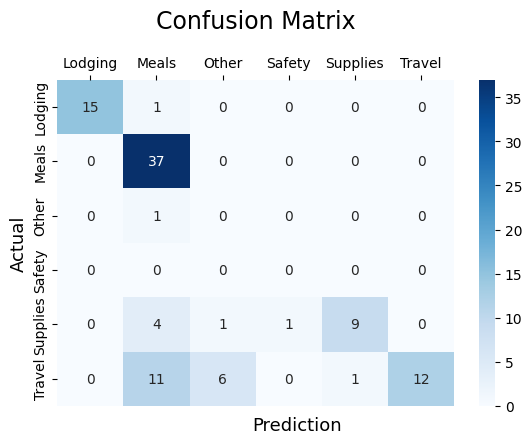

              precision    recall  f1-score   support

     Lodging       1.00      0.94      0.97        16
       Meals       0.69      1.00      0.81        37
       Other       0.00      0.00      0.00         1
      Safety       0.00      0.00      0.00         0
    Supplies       0.90      0.60      0.72        15
      Travel       1.00      0.40      0.57        30

    accuracy                           0.74        99
   macro avg       0.60      0.49      0.51        99
weighted avg       0.86      0.74      0.74        99



In [11]:
calculate_accuracies(llama_8binstruct)
print()
build_confusion_matrix(llama_8binstruct)

The model appears to overly weight the "Meals" category. The precision value of Meals shows that when the model predicts "Meals", it is only correct 69% of the time. It's pretty good at identifying Lodging: 0 false positives and only 1 false negative. 

### Amazon Titan Text Express

**Top P** = .5 <br>
**Temperature** = .5 <br>

In [12]:
titan_text_lite = pd.read_csv('data/Spreadsheets/receipts_titantextlite_promptv2.csv')
titan_text_lite.head()

,receipt_extract,object_name,date,subtotal,total,category,extracted_date,extracted_total,predicted_category
0,"{""NAME"": ""DELTA"", ""INVOICE_RECEIPT_DATE"": ""22S...",Airfare1.jpg,09/22/2024,45.00,45.00,Travel,09/22/2024,45.00,Meals
1,"{""NAME"": ""Alaska Airlines Alaska Fairbanks ANC...",Airfare2.jpg,11/13/2024,545.11,614.69,Travel,11/13/2024,614.69,Travel
2,"{""NAME"": ""National."", ""items"": {""item0"": ""TIME...",CarRental1.jpg,12/15/2024,355.00,505.63,Travel,12/15/2024,505.63,Travel
3,"{""AMOUNT_PAID"": ""$0.00"", ""items"": {""item0"": ""C...",CarRental2.jpg,01/01/1900,173.14,173.14,Travel,01/01/1899,173.14,Travel
4,"{""ADDRESS"": ""BOZEMAN INTL ARPT\n850 GALLATIN F...",CarRental3.jpg,12/20/2024,272.83,319.18,Travel,01/01/1899,319.18,Meals


Total Receipts Analyzed: 99
Accuracies:
	Amount: 85.86%
	Date: 77.78%
	Category: 69.70%
Misses:
	Amount: [25, 26, 30, 37, 42, 46, 61, 63, 75, 78, 79, 86, 87, 95]
	Date: [3, 4, 5, 6, 7, 19, 21, 22, 23, 24, 26, 47, 53, 58, 61, 64, 68, 70, 76, 85, 95, 98]
	Category: [0, 4, 6, 8, 9, 10, 11, 16, 22, 24, 26, 41, 43, 44, 46, 47, 50, 52, 53, 58, 60, 66, 75, 76, 80, 81, 86, 89, 91, 93]



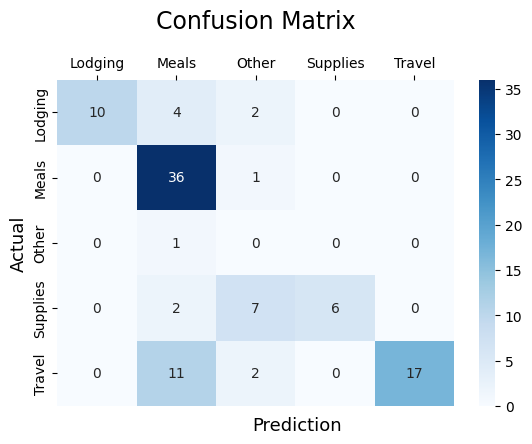

              precision    recall  f1-score   support

     Lodging       1.00      0.62      0.77        16
       Meals       0.67      0.97      0.79        37
       Other       0.00      0.00      0.00         1
    Supplies       1.00      0.40      0.57        15
      Travel       1.00      0.57      0.72        30

    accuracy                           0.70        99
   macro avg       0.73      0.51      0.57        99
weighted avg       0.87      0.70      0.73        99



In [13]:
calculate_accuracies(titan_text_lite)

print()
build_confusion_matrix(titan_text_lite)

This model also favors Meals. It's not inherently a bad thing because the vast majority of receipts employees turn in for reimbursement are for Meals. Which is also why the majority of tested receipts are Meals. Other than that, it seems to do well on Travel but poorly on Supplies and lodging compared to llama 3b.

## Llama 3 70B Instruct

In [16]:
llama_seventyb = pd.read_csv('data/Spreadsheets/receipts_llama_70binstruct.csv')
llama_seventyb.head()

,receipt_extract,object_name,date,subtotal,total,category,extracted_date,extracted_total,predicted_category
0,"{""NAME"": ""DELTA"", ""INVOICE_RECEIPT_DATE"": ""22S...",Airfare1.jpg,09/22/2024,45.00,45.00,Travel,09/22/2024,45.00,Travel
1,"{""NAME"": ""Alaska Airlines Alaska Fairbanks ANC...",Airfare2.jpg,11/13/2024,545.11,614.69,Travel,11/13/2024,614.69,Travel
2,"{""NAME"": ""National."", ""items"": {""item0"": ""TIME...",CarRental1.jpg,12/15/2024,355.00,505.63,Travel,12/15/2024,505.63,Travel
3,"{""AMOUNT_PAID"": ""$0.00"", ""items"": {""item0"": ""C...",CarRental2.jpg,01/01/1900,173.14,173.14,Travel,01/01/1899,173.14,Travel
4,"{""ADDRESS"": ""BOZEMAN INTL ARPT\n850 GALLATIN F...",CarRental3.jpg,12/20/2024,272.83,319.18,Travel,01/01/1899,319.18,Travel


In [17]:
llama_seventyb['predicted_category'] = llama_seventyb['predicted_category'].fillna("Other")

Total Receipts Analyzed: 99
Accuracies:
	Amount: 85.86%
	Date: 77.78%
	Category: 88.89%
Misses:
	Amount: [25, 26, 30, 37, 42, 46, 61, 63, 75, 78, 79, 86, 87, 95]
	Date: [3, 4, 5, 6, 7, 19, 21, 22, 23, 24, 26, 47, 53, 58, 61, 64, 68, 70, 76, 85, 95, 98]
	Category: [8, 9, 10, 24, 41, 77, 87, 88, 91, 93, 94]



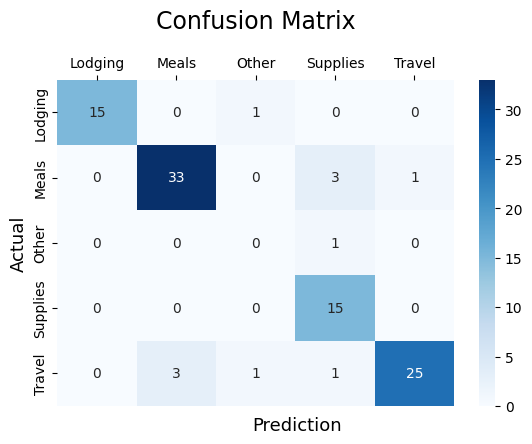

              precision    recall  f1-score   support

     Lodging       1.00      0.94      0.97        16
       Meals       0.92      0.89      0.90        37
       Other       0.00      0.00      0.00         1
    Supplies       0.75      1.00      0.86        15
      Travel       0.96      0.83      0.89        30

    accuracy                           0.89        99
   macro avg       0.73      0.73      0.72        99
weighted avg       0.91      0.89      0.89        99



In [18]:
calculate_accuracies(llama_seventyb)
print()
build_confusion_matrix(llama_seventyb)

Really good. All models seem to have difficulty with Travel receipts. This may have more to do with receipt quality.